# Probability of Probabilities

The following notebook is inspired by [3b1b's video on probability of probabilities](https://www.youtube.com/watch?v=8idr1WZ1A7Q).
This should serve as helping getting an understanding for probability of probabilities, Bayes Rule, and maybe enlighten someone in how to choose sellers when buying stuff online.

There are two distinct questions one has to ask:

1. What is the model?
2. What are you optimizing?

## Model
Each seller produces random experiences, either positive or negative.
Also, each seller has a constant underlying probability of giving a positive experience, denoted as $s$.
The whole challenge is that **$s$ is not known**.

## Optimizing
The user wants to maximize her/his probability of having a positive experience when buying stuff from a certain seller.

In order to set this up and analyze the problem further, at first an underlying success rate is assumed.
Given a defined number of reviews, a sequence of reviews is generated by randomly picking a number between $\left[0, 1 \right]$ and if that number is smaller than $s$, this is marked as a positive review, and as negative review otherwise.
Note that, this is done for an **asummed** success rate since this is what is actually unknown.

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import binom as binom_coeff
from scipy.stats import binom as binom_func

# use the searborn style
plt.style.use("seaborn")

In [2]:
# define a random number generator
rng = np.random.default_rng()

# define an assumed underlying success rate, although we do not know this (by now)
assumed_success_rate = 0.95

# define the number of simulations to be run and the number of individual seller reviews
num_sims = 100_000
num_reviews = 50
# define a hist variable which stores the number of positive reviews
hist = np.zeros((1, num_reviews), dtype=int)
for i in range(num_sims):
    # generate random numbers between 0 and 1 of size 10
    rand = rng.random(size=(1, num_reviews))
    # define a positive review if the random number is smaller than the assumed success rate and a negative review otherwise
    reviews = rand <= assumed_success_rate
    # get the number of positive reviews
    count = np.sum(reviews)
    # add 1 to the corresponding entry in hist
    hist[:, count - 1] += 1
# divide the number of values by the total number of simulations to get the percentage
hist = hist / num_sims

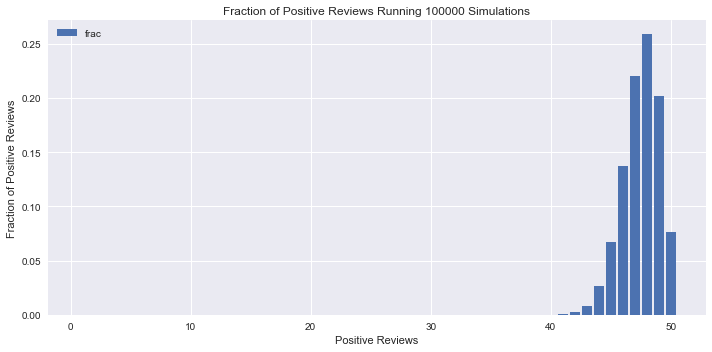

In [3]:
nrows, ncols = 1, 1
fig1 = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(nrows, ncols, figure=fig1)
ax1 = fig1.add_subplot(gs[0, 0])
x = np.arange(1, num_reviews + 1)[np.newaxis, :]
ax1.bar(x[0, :], height=hist[0, :], label="frac")
ax1.legend()
ax1.set(ylabel="Fraction of Positive Reviews", xlabel="Positive Reviews", title=f"Fraction of Positive Reviews Running {num_sims} Simulations")
fig1.tight_layout()

There are many different possible success rates for each seller (a number between $\left[0, 1 \right]$).
Each success rate has a probability of occuring seeing the current data, a **probability of probabilities**.
Herein, the problem is that there is uncertainty about the underlying success rate $s$, whereas when flipping a coin, the success rate is (ideally) $0.5$.

Again, when assuming an underlying success rate $s$, at first it would be interesting to know the probability of the number of positive and negative reviews (this is denoted as $+$ and $-$ in this case, respectively) given $s$.
Mathematically, this is expressed as:
$$ P(+, - | s)\text{, i.e. } P(\text{data}|s)$$
Thus, the question is what is the probability of the data (negative or positive reviews) given an assumed succes rate.
Note that the crucial underlying assumption is that **each review is independent of the last**, i.e. randomly grabbing into a bag, pulling something out, then putting it back in, and repeat the whole process, also known as [urn problem](https://en.wikipedia.org/wiki/Urn_problem).

## Binomial Distribution
The answer to the above question is the binomial distribution, in which the probability mass function (PMF) (also called proability density function PDF) is defined as:
$$ P(+,-|s) = \left( \begin{matrix} \text{Total} \\ + \end{matrix} \right) (s)^{+}(1-s)^{-} $$
Herein, $\text{Total}$ denotes the total number of reviews.
The term $\left( \begin{matrix} \text{Total} \\ + \end{matrix} \right)$ reads "$\text{Total}$ choose $+$", and denotes the total number of possibilites one can arrange the number of positive and negative reviews.
This is also known as the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), which in turn is defined as:
$$ \left( \begin{matrix} n \\ k \end{matrix} \right) = \dfrac{n!}{k!(n - k)!} $$
The binomial distribution comes up when a random event can go one of two ways and this event is repeated a several number of times.
What is searched for is the probability of getting various different totals.


Assume the goal is to calculate the probability of 48 positive and 2 negative reviews assuming a success rate of 0.95.

In [4]:
# define the number of positive and negative reviews
pos = 48
neg = num_reviews - pos
p_48_2 = binom_coeff(num_reviews, pos) * assumed_success_rate ** pos * (1 - assumed_success_rate) ** neg
print(f"Probability P({pos}, {neg}|{assumed_success_rate}) = {p_48_2 * 100:.2f}%")

Probability P(48, 2|0.95) = 26.11%


Thus, the probability of seeing 48 positive and 2 negative reviews of a seller assuming a success rate of 0.95 is 26.11%.

This is also the result of the simulation, in which the highest bar corresponds to the probability mentioned before (see below).

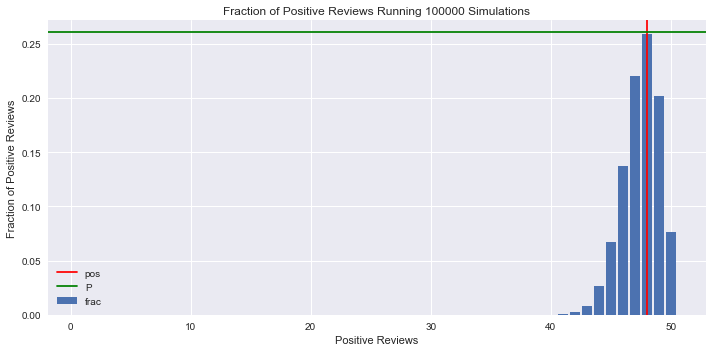

In [5]:
ax1.axvline(pos, color="r", label="pos")
ax1.axhline(p_48_2, color="g", label="P")
ax1.legend()
fig1

When computing the PMF of the numbers given, the result aligns perfectly with what was expected.

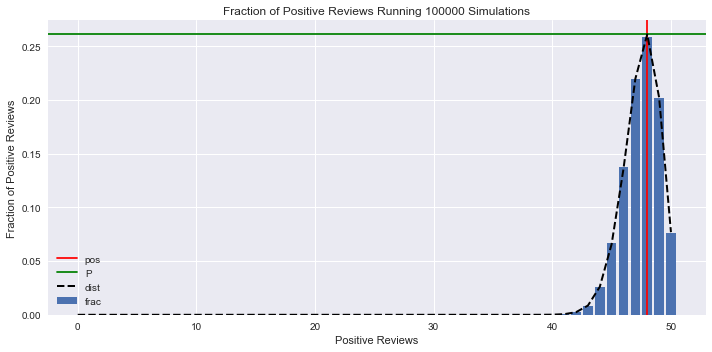

In [6]:
mean, var, skew, kurt = binom_func.stats(num_reviews, assumed_success_rate, moments="mvsk")
pmf = binom_func.pmf(np.arange(0, num_reviews + 1), num_reviews, assumed_success_rate)
ax1.plot(pmf, linestyle="dashed", linewidth=2, color="k", label="dist")
ax1.legend()
fig1

## Influence of the Success Rate

Since the ultimate goal is to predict the true underlying success rate $s$ of a seller given the data available, i.e.
$$ P(s | \text{data}) $$
one can first look at different values for $s$, since this can be any number between 0 and 1.

### Reminder
Originally, the goal was to find the probability $P(48, 2|0.95)$ (48 positive and 2 negative revies given $s=0.95$).
This probability can vary depending on the values of $s$.



In [7]:
# define different values for s
s = np.linspace(0, 1, 200)
# calculate the probability of
p_s = binom_func.pmf(pos, num_reviews, s)
# get the index of the maximum value, and the corresponding maximum values
idx = np.argmax(p_s)
max_s = s[idx]
max_p = p_s[idx]

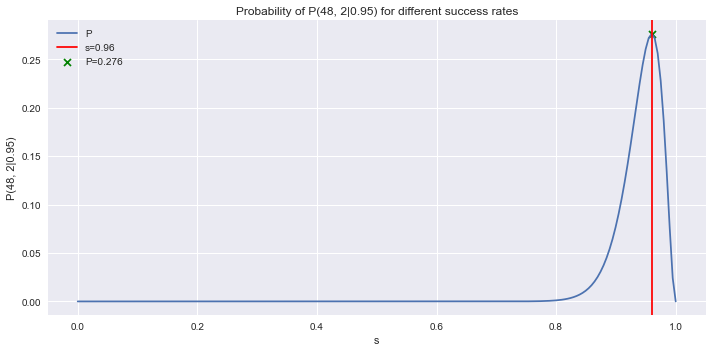

In [8]:
nrows, ncols = 1, 1
fig2 = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(nrows, ncols, figure=fig2)
ax2 = fig2.add_subplot(gs[0, 0])
ax2.plot(s, p_s, label="P")
ax2.axvline(max_s, color="r", label=f"s={max_s:.3}")
ax2.scatter(max_s, max_p, marker="x", color="g", label=f"P={max_p:.3f}")
ax2.set(xlabel="s", ylabel=f"P({pos}, {neg}|{assumed_success_rate})", title=f"Probability of P({pos}, {neg}|{assumed_success_rate}) for different success rates")
ax2.legend()
fig2.tight_layout()

As seen in the plot above, the success rate at which the probability $P(48, 2|s)$ is at its maximum is at $s=96$% with a probability of $P=27.6$%.